<a href="https://colab.research.google.com/github/shouvikcirca/PCB_Defect_Detection/blob/master/PCB_Notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import math
import torch.nn as nn

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
X = np.load('drive/My Drive/Copy of xtrain.npy')
y = np.load('drive/My Drive/Copy of ytrain.npy')

In [14]:
# X = torch.from_numpy(X)
# X = X.permute(0,3,1,2)
# y = torch.from_numpy(y)
X.shape, y.shape

(torch.Size([298, 3, 300, 300]), torch.Size([298]))

In [0]:
pickle.dump(X, open("augX.pkl", 'wb'), protocol=4)
# pickle.dump(resized_imageset, open(f'resized_imageset1.pkl', 'wb'))
# X = pickle.load(open(f'resized_imageset1.pkl', 'rb'))

Normalizing


In [0]:
def getNormalized(X):
  flattened_channels = X.reshape(3,-1)
  channel_mean = flattened_channels.mean(dim = 1)
  channel_stddev = flattened_channels.std(dim = 1)
  preprocess2 = transforms.Compose([
                      transforms.Normalize(channel_mean, channel_stddev)
  ])


  temptwo = torch.tensor([])
  for i in range(X.shape[0]):
    a = preprocess2(X[i])
    temptwo = torch.cat([temptwo, a.reshape(1,3,300,300)])
  
  return temptwo


Resizing

In [0]:
def imageSetResize(newSize,X):
  preprocess1 = transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.Resize(newSize),
                        transforms.ToTensor()])
  
  temp = torch.tensor([])
  for i in range(X.shape[0]):
    a = preprocess1(X[i])
    temp = torch.cat([temp, a.reshape(1,3,newSize,newSize)])

  return temp 

In [0]:
normalized_imageset = getNormalized(X.float())

In [0]:
resized_imageset = imageSetResize(256,normalized_imageset)

In [26]:
resized_imageset.shape

torch.Size([298, 3, 256, 256])

Creating train and test set

In [42]:
# shuffled_indices = torch.randperm(resized_imageset.shape[0])
# ul = math.floor(0.8*resized_imageset.shape[0])
# train_indices = shuffled_indices[:ul]
# test_indices = shuffled_indices[ul:]

train_indices.shape[0] + test_indices.shape[0]

298

In [0]:
X_train = resized_imageset[train_indices]
y_train = y[train_indices]

X_test = resized_imageset[test_indices]
y_test = y[test_indices]

Checking Distribution

In [57]:
(y_train == 0).sum(), (y_train == 1).sum(), (y_test == 0).sum(), (y_test == 1).sum()

(tensor(120), tensor(118), tensor(29), tensor(31))

238

In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=527f56e309d22b0578ff9afa5f8ccb78992540fc5e09ac0e0e0c4359370e364d
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.4 GB  | Proc size: 157.0 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [8]:
torch.cuda.is_available()

True

In [12]:
device = torch.device('cuda:0')
device, torch.cuda.device_count()

(device(type='cuda', index=0), 1)

In [21]:
# xxxx = torch.from_numpy(X)
# XXXX = xxxx[:4]
# XXXX = XXXX.permute(0,3,1,2)

# flattened_channels = XXXX.reshape(3,-1)
# channel_mean = flattened_channels.mean(dim = 1)
# channel_stddev = flattened_channels.std(dim = 1)
# pppp = transforms.Compose([
                          # transforms.Normalize(channel_mean, channel_stddev)
# ])



TypeError: ignored

In [0]:
############################################################

In [13]:
import torch.multiprocessing as mp
mp.cpu_count()

4

In [0]:
###########################################################

In [0]:
class PCBdataset(Dataset):
  def __init__(self, numpy_file, label_file, transform):
    self.image_file = numpy_file
    self.label_file = label_file
    self.transform = transform
    
    
  def __len__(self):
    return self.image_file.shape[0]

  def __getitem__(self, idx):

    image = self.image_file[idx]
    if(self.transform):
      image = self.transform(self.image_file[idx])

    di = {'image':image, 'label':self.label_file[idx].item()}
    return di


# .permute(1,2,0)

In [0]:
import torchvision.transforms.functional as F
t = F.to_pil_image(a[0]['image'])

In [0]:
a = PCBdata[0]['image']

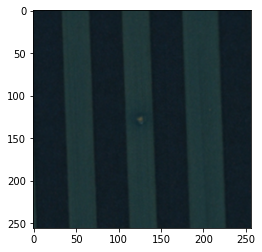

In [0]:
plt.imshow(a)

In [0]:
a = torch.tensor([1.,2.,3.,4.])

b = a[0]
c = a[1]
d = a[2]
e = a[3]